# Modelos de clasificación

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report

Como primer paso analizamos la posible correlación entre los ratios obtenidos en el notbook ratios

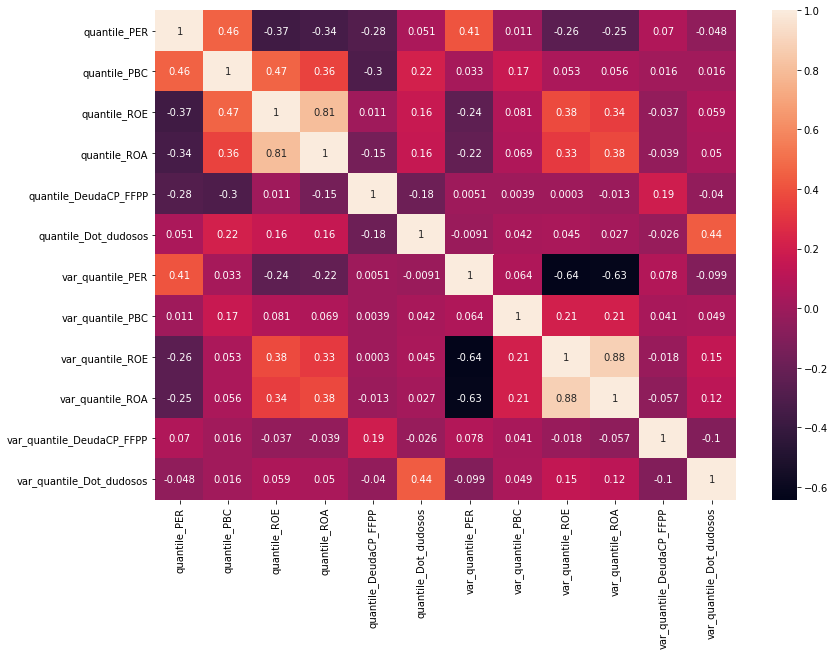

In [2]:
df = pd.read_csv("../tablas/dataformodel.csv", usecols=['quantile_PER', 'var_quantile_PER',
                                                        'quantile_PBC', 'var_quantile_PBC',
                                                        'quantile_ROA', 'var_quantile_ROA',
                                                        'quantile_ROE', 'var_quantile_ROE',
                                                        'quantile_DeudaCP_FFPP', 'var_quantile_DeudaCP_FFPP',
                                                        'quantile_Dot_dudosos', 'var_quantile_Dot_dudosos',
                                                        'Etiqueta'])

corrMatrix = df.corr()
plt.figure(figsize=(13,9))
sn.heatmap(corrMatrix, annot=True)
plt.show()

Podemos observar una correlación muy fuerte entre el ROE y el ROA, así que prescindimos del ROE, así como de su variación.

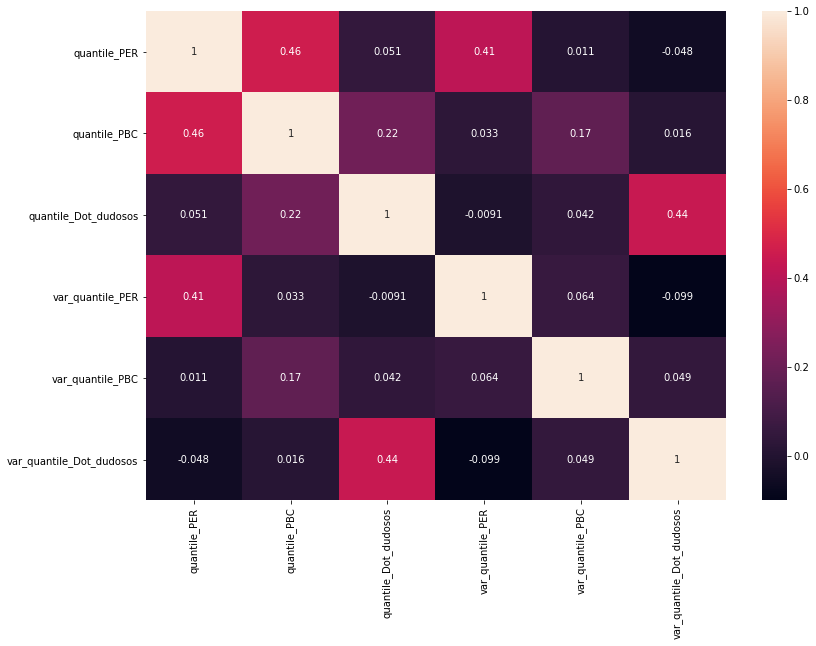

In [3]:
df = pd.read_csv("../tablas/dataformodel.csv", usecols=['quantile_PER', 'var_quantile_PER',
                                                        'quantile_PBC', 'var_quantile_PBC',
                                                        'quantile_Dot_dudosos', 'var_quantile_Dot_dudosos',
                                                        'Etiqueta'])

corrMatrix = df.corr()
plt.figure(figsize=(13,9))
sn.heatmap(corrMatrix, annot=True)
plt.show()

Eliminamos nans

In [4]:
df=df.replace([np.inf, -np.inf], np.nan)
for column in df.columns:
    df=df[df[column].notnull()]
df=df.reset_index(drop=True)

In [5]:
df.describe()

,quantile_PER,quantile_PBC,quantile_Dot_dudosos,var_quantile_PER,var_quantile_PBC,var_quantile_Dot_dudosos
count,916.000000,916.000000,916.000000,916.000000,916.000000,916.000000
mean,50.565117,50.240817,49.476625,-0.046801,0.011579,0.178545
std,27.684441,27.957431,28.061415,22.799217,9.694561,24.826803
min,2.941176,2.941176,2.941176,-91.176471,-58.823529,-91.176471
25%,26.470588,26.470588,23.529412,-8.823529,-2.941176,-11.764706
50%,50.000000,50.000000,50.000000,0.000000,0.000000,0.000000
75%,73.529412,73.529412,73.529412,9.558824,5.882353,11.764706
max,100.000000,100.000000,100.000000,91.176471,55.882353,88.235294


## Preparación del modelo

In [6]:
variables = list(df.columns)
variables.remove('Etiqueta')
X = df[variables].values
y = df['Etiqueta']

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, shuffle=False)

### LogisticRegression

In [8]:
from sklearn.linear_model import LogisticRegression
# Create an instance of the classifier
clf=LogisticRegression(max_iter=200)

In [9]:
clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
cross_val_score(clf,X_train,y_train,cv=10,scoring="accuracy").mean()

0.5710107367641614

In [11]:
cross_val_score(clf,X_train,y_train,cv=3,scoring=make_scorer(recall_score, average = 'weighted')).mean()

0.5901639344262296

In [12]:
a=df.groupby('Etiqueta').count()
a['%']= a.iloc[0:,1]/a.iloc[0:,1].sum()
a

,quantile_PER,quantile_PBC,quantile_Dot_dudosos,var_quantile_PER,var_quantile_PBC,var_quantile_Dot_dudosos,%
Etiqueta,,,,,,,
Mejor,443,443,443,443,443,443,0.483624
Peor,473,473,473,473,473,473,0.516376


In [13]:
print(classification_report(y_test,clf.predict(X_test)))

              precision    recall  f1-score   support

       Mejor       0.55      0.27      0.36       100
        Peor       0.46      0.74      0.57        84

    accuracy                           0.48       184
   macro avg       0.51      0.50      0.46       184
weighted avg       0.51      0.48      0.46       184



In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, clf.predict(X_test))
print(confusion_matrix)

[[27 73]
 [22 62]]


In [15]:
clf.score(X_test, y_test)

0.483695652173913

### Kneighbors

In [16]:
# Load the library
from sklearn.neighbors import KNeighborsClassifier
# Create an instance of the classifier
clfk=KNeighborsClassifier(n_neighbors=5)
# Fit the data
clfk.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [17]:
from sklearn.model_selection import GridSearchCV

In [18]:
knGrid = GridSearchCV(clfk,cv=5,scoring="accuracy",param_grid={'n_neighbors':np.arange(1,20)})
knGrid.fit(X_train,y_train)
knGrid.best_params_

{'n_neighbors': 17}

In [19]:
clfk=KNeighborsClassifier(n_neighbors=15)
clfk.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

In [20]:
cross_val_score(clfk,X_train,y_train,cv=5,scoring="accuracy").mean()

0.5327928431646631

In [21]:
print(classification_report(y_test,clfk.predict(X_test)))

              precision    recall  f1-score   support

       Mejor       0.57      0.46      0.51       100
        Peor       0.48      0.58      0.52        84

    accuracy                           0.52       184
   macro avg       0.52      0.52      0.52       184
weighted avg       0.53      0.52      0.52       184



In [22]:
clfk.score(X_test, y_test, sample_weight=None)

0.5163043478260869

### Decision Tree

In [23]:
# Import library
from sklearn.tree import DecisionTreeClassifier

In [24]:
clfTree = GridSearchCV(DecisionTreeClassifier(),
                      param_grid = {"max_depth":np.arange(2,10),
                                   "min_samples_leaf": np.arange(2,20,1)},
                      cv=5,
                       scoring="accuracy"
                      )
clfTree.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([2, 3, 4, 5, 6, 7, 8, 9]),
       

In [25]:
clfTree.best_score_

0.5889199515422607

In [26]:
clfTree.best_params_

{'max_depth': 2, 'min_samples_leaf': 2}

In [27]:
best_max_depth=clfTree.best_params_.get('max_depth')
best_min_samples_leaf=clfTree.best_params_.get('min_samples_leaf')

In [28]:
clfTree = DecisionTreeClassifier(random_state=0, max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf)
clfTree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [29]:
 clfTree.score(X_test, y_test, sample_weight=None)

0.5163043478260869

In [30]:
print(classification_report(y_test,clfTree.predict(X_test)))

              precision    recall  f1-score   support

       Mejor       0.58      0.38      0.46       100
        Peor       0.48      0.68      0.56        84

    accuracy                           0.52       184
   macro avg       0.53      0.53      0.51       184
weighted avg       0.54      0.52      0.51       184



### Random Forest

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
clf_rf0 = RandomForestClassifier(max_depth=3,
                               min_samples_leaf=5,
                               n_estimators=100,
                               n_jobs=-1)

In [33]:
clf_rf = GridSearchCV(clf_rf0,
                      param_grid = {"max_depth":np.arange(2,10),
                                   "min_samples_leaf": np.arange(2,20,2)},
                      cv=4,
                       scoring="accuracy"
                      )
clf_rf.fit(X_train,y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=3,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=5,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_sta

In [34]:
print(clf_rf.best_score_)
print(clf_rf.best_params_)

0.5765027322404372
{'max_depth': 2, 'min_samples_leaf': 10}


In [35]:
clf_rf = GridSearchCV(clf_rf0,
                      param_grid = {"max_depth":np.arange(2,10),
                                   "min_samples_leaf": np.arange(2,20,2)},
                      cv=4,
                       scoring=make_scorer(recall_score, average = 'weighted')
                      )
clf_rf.fit(X_train,y_train)

GridSearchCV(cv=4, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=3,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=5,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_sta

In [36]:
print(clf_rf.best_score_)
print(clf_rf.best_params_)

0.5765027322404372
{'max_depth': 2, 'min_samples_leaf': 4}


In [37]:
clf_rf1 = RandomForestClassifier(max_depth=6,
                               min_samples_leaf=8,
                               n_estimators=300,
                               n_jobs=-1)
clf_rf1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [38]:
cross_val_score(clf_rf1,X_train,y_train,cv=4,scoring=make_scorer(recall_score, average = 'weighted')).mean()

0.5437158469945356

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test,clf_rf1.predict(X_test)))

              precision    recall  f1-score   support

       Mejor       0.62      0.26      0.37       100
        Peor       0.48      0.81      0.60        84

    accuracy                           0.51       184
   macro avg       0.55      0.53      0.48       184
weighted avg       0.56      0.51      0.47       184



In [40]:
print(confusion_matrix(y_test,clf_rf1.predict(X_test)))

[[26 74]
 [16 68]]
